In [1]:
import pandas as pd
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
from pathlib import Path
import json
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from datetime import datetime
import re
from scipy import stats
from scipy.optimize import curve_fit
import numpy as np
import statsmodels.api as sm
from matplotlib import colormaps
from tqdm.notebook import tqdm
import helpers
from sklearn.metrics import r2_score
from IPython.display import clear_output
from typing import Callable

from mri_data import file_manager as fm

## Load Data

In [2]:
drive_root = fm.get_drive_root()
dataroot = drive_root / "3Tpioneer_bids"
data_dir = Path("/home/srs-9/Projects/ms_mri/data")
fig_path = Path("/home/srs-9/Projects/ms_mri/analysis/thalamus/figures_tables/gradient_analysis")
r_dataroot = Path("/home/srs-9/Projects/ms_mri/analysis/thalamus/R_data")

choroid_volumes = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/choroid_aschoplex_volumes.csv", index_col="subid"
).dropna()
tiv = pd.read_csv("/home/srs-9/Projects/ms_mri/data/tiv_data.csv", index_col="subid")

df = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/clinical_data_processed.csv", index_col="subid"
)
sdmt = pd.read_csv("/home/srs-9/Projects/ms_mri/analysis/thalamus/SDMT_sheet.csv", index_col="subid")
df = df.join([choroid_volumes, tiv, sdmt['SDMT']])
df['SDMT'] = pd.to_numeric(df['SDMT'], errors='coerce')
df['thalamus_sqrt'] = np.sqrt(df['thalamus'])
df['thalamus_curt'] = np.sqrt(df['thalamus']**3)
df['cortical_thickness_inv'] = 1 / df['cortical_thickness']
df_z = df.copy()
numeric_cols = df.select_dtypes(include='number').columns
df_z[numeric_cols] = df_z[numeric_cols].apply(stats.zscore, nan_policy="omit")

viridis = colormaps['viridis'].resampled(20)

colors = helpers.get_colors()

In [3]:
df_thomas = pd.read_csv(data_dir / "hipsthomas_vols.csv", index_col="subid")
cols_orig = df_thomas.columns
new_colnames = {}
for col in df_thomas.columns:
    new_col = re.sub(r"(\d+)-([\w-]+)", r"\2_\1", col)
    new_col = re.sub("-", "_", new_col)
    new_colnames[col] = new_col
df_thomas = df_thomas.rename(columns=new_colnames)
df_thomas_norm = df_thomas.apply(lambda col: col / df_thomas['THALAMUS_1'])
df_thomas_z = df_thomas.apply(stats.zscore, nan_policy="omit")
df_thomas_norm_z = df_thomas_norm.apply(stats.zscore, nan_policy="omit")

df_thomas_left = pd.read_csv(data_dir / "hipsthomas_left_vols.csv", index_col="subid")
df_thomas_left = df_thomas_left.rename(columns=new_colnames)
df_thomas_left_z = df_thomas_left.apply(stats.zscore, nan_policy="omit")

df_thomas_right = pd.read_csv(data_dir / "hipsthomas_right_vols.csv", index_col="subid")
df_thomas_right = df_thomas_right.rename(columns=new_colnames)
df_thomas_right_z = df_thomas_right.apply(stats.zscore, nan_policy="omit")


thalamic_nuclei = [2, 4, 5, 6, 7, 8, 9, 10, 11, 12]
ignore_structs1 = ["THALAMUS_1", "Amy_34", "GP_33", "Cla_28", "Acc_26", "Hb_13", "MTT_14"]
ignore_structs2 = ["THALAMUS_1", "Amy_34", "GP_33", "Hb_13", "MTT_14"]

thalamic_nuclei_str = [str(i) for i in thalamic_nuclei]

hips_thomas_ref = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/hipsthomas_struct_index.csv", index_col="index"
)['struct']
hips_thomas_invref = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/hipsthomas_struct_index.csv", index_col="struct"
)['index']
# hips_thomas_ref.rename(columns={"struct": "struct_name"}, inplace=True)

all_struct_inds = hips_thomas_ref[~hips_thomas_ref.isin(['THALAMUS_1', 'GP_33', 'Amy_34'])].index


def combine_nuclei2(df):
    df2 = pd.DataFrame()
    df2['anterior'] = df['AV_2']
    df2['ventral'] = df['VA_4'] + df['VLa_5'] + df['VLP_6'] + df['VPL_7']
    df2['medial'] = df['MD_Pf_12'] + df['CM_11'] 
    df2['posterior'] = df['Pul_8'] + df['LGN_9'] + df['MGN_10']
    df2['THALAMUS_1'] = df['THALAMUS_1']
    return df2

mni_combined_dists = pd.read_csv('/home/srs-9/Projects/ms_mri/data/mni_combined_nuclei_centroid_centroid_dists.csv', index_col="index")

df_thomas2 = combine_nuclei2(df_thomas)
grouped_nuclei = df_thomas2.columns[~df_thomas2.columns.isin(["THALAMUS_1"])]
df_thomas2_z = df_thomas2.apply(stats.zscore, nan_policy="omit")
df_thomas2_norm = df_thomas2.apply(lambda col: col / df_thomas['THALAMUS_1'])
df_thomas2_norm_z = df_thomas2_norm.apply(stats.zscore, nan_policy="omit")

df_thomas2_left = combine_nuclei2(df_thomas_left)
df_thomas2_left_z = df_thomas2_left.apply(stats.zscore, nan_policy="omit")
df_thomas2_norm_left = df_thomas2.apply(lambda col: col / df_thomas['THALAMUS_1'])
df_thomas2_norm_left_z = df_thomas2_norm_left.apply(stats.zscore, nan_policy="omit")

df_thomas2_right = combine_nuclei2(df_thomas_right)
df_thomas2_right_z = df_thomas2_right.apply(stats.zscore, nan_policy="omit")
df_thomas2_norm_right = df_thomas2.apply(lambda col: col / df_thomas['THALAMUS_1'])
df_thomas2_norm_right_z = df_thomas2_norm_right.apply(stats.zscore, nan_policy="omit")

choroid_dists1 = pd.read_csv(data_dir / "centroid-choroid_centroid2.csv", index_col="subid")
dists_newcols = {str(i): f"{hips_thomas_ref[i]}_dist" for i in hips_thomas_ref.index}
choroid_dists1 = choroid_dists1.rename(columns=dists_newcols)
choroid_dists1_z = choroid_dists1.apply(stats.zscore, nan_policy="omit")

choroid_dists = pd.read_csv(data_dir / "centroid-choroid_centroid-left.csv", index_col="subid")
choroid_dists = choroid_dists.rename(columns=dists_newcols)
choroid_dists_z = choroid_dists.apply(stats.zscore, nan_policy="omit")

choroid_dists_right = pd.read_csv(data_dir / "centroid-choroid_centroid-right.csv", index_col="subid")
choroid_dists_right = choroid_dists_right.rename(columns=dists_newcols)
choroid_dists_right_z = choroid_dists_right.apply(stats.zscore, nan_policy="omit")

choroid_dists_mean = (choroid_dists + choroid_dists_right) / 2

choroid_dists2 = pd.DataFrame()
choroid_dists2['ventral_dist'] = choroid_dists[["VA_4_dist", "VLa_5_dist", "VLP_6_dist", "VPL_7_dist"]].mean(axis=1)
choroid_dists2['posterior_dist'] = choroid_dists[["Pul_8_dist", "LGN_9_dist", "MGN_10_dist"]].mean(axis=1)
choroid_dists2['medial_dist'] = choroid_dists[["MD_Pf_12_dist", "CM_11_dist", "MGN_10_dist"]].mean(axis=1)
choroid_dists2['anterior_dist'] = choroid_dists["AV_2_dist"]
choroid_dists2_z = choroid_dists2.apply(stats.zscore, nan_policy="omit")


choroid_dists_right2 = pd.DataFrame()
choroid_dists_right2['ventral_dist'] = choroid_dists_right[["VA_4_dist", "VLa_5_dist", "VLP_6_dist", "VPL_7_dist"]].mean(axis=1)
choroid_dists_right2['posterior_dist'] = choroid_dists_right[["Pul_8_dist", "LGN_9_dist", "MGN_10_dist"]].mean(axis=1)
choroid_dists_right2['medial_dist'] = choroid_dists_right[["MD_Pf_12_dist", "CM_11_dist", "MGN_10_dist"]].mean(axis=1)
choroid_dists_right2['anterior_dist'] = choroid_dists_right["AV_2_dist"]
choroid_dists_right2_z = choroid_dists_right2.apply(stats.zscore, nan_policy="omit")


ventricle_dists_sdt_left = pd.read_csv(
    data_dir / "centroid-ventricle_SDT-left.csv", index_col="subid"
)
ventricle_dists_sdt_right = pd.read_csv(
    data_dir / "centroid-ventricle_SDT-right.csv", index_col="subid"
)
ventricle_dists_sdt = (ventricle_dists_sdt_left + ventricle_dists_sdt_right) / 2

ventricle_dists_sdt = ventricle_dists_sdt.rename(columns=dists_newcols)
ventricle_dists_sdt_z = ventricle_dists_sdt.apply(stats.zscore, nan_policy="omit")

ventricle_dists2 = pd.DataFrame()
ventricle_dists2['medial_dist'] = (ventricle_dists_sdt.MD_Pf_12_dist + ventricle_dists_sdt.CM_11_dist) / 2
ventricle_dists2['posterior_dist'] = (ventricle_dists_sdt.Pul_8_dist + ventricle_dists_sdt.LGN_9_dist + ventricle_dists_sdt.MGN_10_dist) / 3
ventricle_dists2['ventral_dist'] = (ventricle_dists_sdt.VA_4_dist + ventricle_dists_sdt.VLa_5_dist + ventricle_dists_sdt.VLP_6_dist + ventricle_dists_sdt.VPL_7_dist) / 4
ventricle_dists2['anterior_dist'] = ventricle_dists_sdt.AV_2_dist
ventricle_dists2_z = ventricle_dists2.apply(stats.zscore, nan_policy='omit')


ventricle_dists = pd.read_csv("/home/srs-9/Projects/ms_mri/data/centroid-ventricle_centroid-left.csv", index_col='subid')

mni_choroid_dists = pd.read_csv("/home/srs-9/Projects/ms_mri/data/mni-centroid-choroid_SDT2.csv")

In [4]:
ventricle_dists_sdt = pd.read_csv(
    data_dir / "centroid-ventricle_SDT_fixed-right.csv", index_col="subid"
)

ventricle_dists_sdt.loc[1011, :] = None
ventricle_dists_sdt.to_csv(data_dir / "centroid_ventricle_SDT-right.csv")

From `compute_exposures2.py`. This is what we want:

In [5]:
mni_dists = pd.read_csv("/home/srs-9/Projects/ms_mri/data/mni_centroid_centroid_dists.csv", index_col="index")
mni_dists['struct'] = hips_thomas_ref
mni_ventricle_dists = pd.read_csv("/home/srs-9/Projects/ms_mri/data/mni_ventricle_exposures3.csv", index_col="index")
# choroid_dists = pd.read_csv("/home/srs-9/Projects/ms_mri/data/centroid-choroid_centroid.csv", index_col="subid")

## Functions

In [6]:
def regress_all_nuclei2(model_data, covariates, pred, structs):
    pvals = {}
    coefs = {}
    se = {}

    if not isinstance(pred, Callable):
        predictor = pred
        def pred(*args, **kwargs):
            return predictor

    if len(covariates) > 0:
        plus_covariates = f"+ {covariates}"
    else:
        plus_covariates = ""
    all_results = {}
    for struct in structs:
        formula = f"{struct} ~ {pred(struct)} {plus_covariates}"
        res = sm.OLS.from_formula(formula, data=model_data).fit()
        pvals[struct] = res.pvalues[pred(struct)]
        coefs[struct] = res.params[pred(struct)]
        se[struct] = res.HC0_se[pred(struct)]
        all_results[struct] = res

    regression_results = pd.DataFrame({"coef": coefs, "pvals": pvals, "se": se})
    regression_results['p_fdr'] = stats.false_discovery_control(
        regression_results['pvals'], method='bh'
    )
    # regression_results = regression_results.sort_values(by="coef", ascending=True)
    regression_results.insert(0, "struct", regression_results.index)
    new_index = []
    for item in regression_results.struct:
        new_index.append(int(re.match(r".+_(\d+)$", item)[1]))

    for i, row in regression_results.iterrows():
        if row['p_fdr'] < 0.05:
            regression_results.loc[i, 'coef_sig'] = row['coef']
        else:
            regression_results.loc[i, 'coef_sig'] = 0

    regression_results.index = new_index
    return regression_results

def dist_name(struct):
    return f"{struct}_dist"


def scatter_hist(
    x, y, ax, ax_histx, ax_histy, nbins=10, light_color=None, dark_color=None,
    xlim=None, ylim=None
):
    if light_color is None:
        light_color = "#1f77b4"
    if dark_color is None:
        dark_color = "#1f77b4"

    # make axes look nice
    ax_histx.set_axis_off()
    ax_histy.set_axis_off()
    ax.xaxis.set_ticks_position("both")
    ax.yaxis.set_ticks_position("both")

    # the scatter plot:
    ax.scatter(x, y, color=dark_color)
    if ylim is None:
        ylim = ax.get_ylim()
    else:
        ax.set_ylim(ylim)
    

    # the histograms
    xbins = np.linspace(np.min(x), np.max(x), nbins)
    ybins = np.linspace(np.min(y), np.max(y), nbins)
    ax_histx.hist(x, bins=xbins, color=light_color, density=True)
    ax_histy.hist(
        y, bins=ybins, orientation="horizontal", color=light_color, density=True
    )

    # kde to plot on histograms
    densityx = stats.gaussian_kde(x.dropna())
    densityy = stats.gaussian_kde(y.dropna())
    xx = np.linspace(np.min(x), np.max(x), 50)
    xy = np.linspace(np.min(y), np.max(y), 50)
    ax_histx.plot(xx, densityx(xx), color=dark_color)
    ax_histy.plot(densityy(xy), xy, color=dark_color)

    ax_histy.set_ylim(ylim)

    if xlim is not None:
        ax.set_xlim(xlim)
        ax_histx.set_xlim(xlim)


def plot_regression(
    data,
    predictor,
    outcome,
    covariates,
    xlabel=None,
    ylabel=None,
    title=None,
    color="blue1",
    xlim=None,
    ylim=None
):
    plus_covariates = ""
    if len(covariates) > 0:
        plus_covariates = f"+ {' + '.join(covariates)}"
    if xlabel is None:
        xlabel = predictor
    if ylabel is None:
        ylabel = outcome
    if title is None:
        title = f"{outcome} vs {predictor}"

    light_color = colors[f"light {color}"]
    dark_color = colors[f"dark {color}"]

    formula = f"{outcome} ~ {predictor} {plus_covariates}"
    res = sm.OLS.from_formula(formula, data=data).fit()
    x, y_pred, y_lims = helpers.get_regression_y(data, res, predictor, outcome)

    fig, axs = plt.subplot_mosaic(
        [["histx", "."], ["scatter", "histy"]],
        figsize=(8, 6),
        width_ratios=(4, 1),
        height_ratios=(1, 4),
        layout="constrained",
    )
    axs["scatter"].plot(x, y_pred, color="black")
    axs["scatter"].fill_between(x, y_lims[0], y_lims[1], alpha=0.4, color=light_color)
    scatter_hist(
        data[predictor],
        data[outcome],
        axs["scatter"],
        axs["histx"],
        axs["histy"],
        light_color=light_color,
        dark_color=dark_color,
        xlim=xlim,
        ylim=ylim
    )

    axs["scatter"].set_ylabel(ylabel)
    axs["scatter"].set_xlabel(xlabel)
    fig.suptitle(title)
    return fig, axs

## Save data for R

In [7]:
choroid_dists = pd.read_csv(data_dir / "centroid-choroid_centroid-left.csv", index_col="subid")
choroid_dists = choroid_dists.apply(stats.zscore, nan_policy="omit")
model_data = df_z.join([df_thomas_z, choroid_dists])

subids_remove = []
for col in choroid_dists.columns:
    check = model_data[col].abs()
    subids_remove.extend(check[check > 4].index.values)

subids_remove = set(subids_remove)

In [15]:
side = "left"

thomas_dfs = {"left": df_thomas_left, "right": df_thomas_right}
dist_files = {"left": "centroid-choroid_centroid-left.csv", "right": "centroid-choroid_centroid-right.csv"}

choroid_dists_load = pd.read_csv(data_dir / dist_files[side], index_col="subid")


choroid_dists_load = choroid_dists_load.apply(stats.zscore, nan_policy="omit")

model_data = df.join([thomas_dfs[side], choroid_dists_load])
# model_data = df.join([df_thomas, choroid_dists_load])
subids_remove = []
for col in choroid_dists_load.columns:
    check = model_data[col].abs()
    subids_remove.extend(check[check > 4].index.values)

subids_remove = set(subids_remove)

model_data = model_data.loc[~model_data.index.isin(subids_remove), :]
model_data = model_data.reset_index()

#! Edit this
model_data = model_data[model_data['dz_type2'].isin(["MS"])]
# model_data = model_data.loc[0:40, :]
choroid_dists_load = choroid_dists_load.loc[choroid_dists_load.index.isin(model_data.subid), :]

ventricle_dists = ventricle_dists.loc[ventricle_dists.index.isin(model_data.subid), :]

id_vars = ["dz_type3", "subid", "age", "Female", "tiv",  "choroid_volume", "dzdur", "THALAMUS_1", "cortical_thickness", "EDSS_sqrt", "SDMT"]
value_vars = hips_thomas_ref[~hips_thomas_ref.isin(['THALAMUS_1'])].values
save_data = model_data.melt(id_vars=id_vars, value_vars=value_vars)
save_data = save_data.set_index(['subid', 'variable'])
for i, row in choroid_dists_load.iterrows():
    for ind in row.index:
        struct = hips_thomas_ref[int(ind)]
        save_data.loc[(i, struct), "choroid_dist"] = row[ind]
for i, row in ventricle_dists.iterrows():
    for ind in row.index:
        struct = hips_thomas_ref[int(ind)]
        save_data.loc[(i, struct), "ventricle_dist"] = row[ind]

save_data = save_data.reset_index()
# save_data = save_data[save_data['variable'].isin(hips_thomas_ref[thalamic_nuclei])]
# save_data = save_data[~save_data['variable'].isin(["Pul_8", "LGN_9"])]
# save_data.to_csv(r_dataroot / f"melted_data_for_R_MS-{side}.csv", index=False)

In [32]:
ventricle_dists_mean = ventricle_dists_sdt.mean()
ventricle_dists_mean

2      3.818932
4      5.207289
5      5.613287
6      6.358232
7      6.507289
8      6.076166
9      6.088828
10     6.788549
11     8.684863
12     7.958141
13     7.318633
14     7.306225
26     3.973924
27     3.180240
28     8.172431
29     7.661266
30     6.289476
31     9.555643
32    10.400058
dtype: float64

In [238]:
left_dists = pd.read_csv(data_dir / "centroid-choroid_centroid-left.csv", index_col="subid")
right_dists = pd.read_csv(data_dir / "centroid-choroid_centroid-right.csv", index_col="subid")
mean_dists = (left_dists + right_dists) / 2

ventricle_dists_sdt0_left = pd.read_csv(
    data_dir / "centroid-ventricle_SDT-left.csv", index_col="subid"
)
ventricle_dists_sdt0_right = pd.read_csv(
    data_dir / "centroid-ventricle_SDT-left.csv", index_col="subid"
)
ventricle_dists_sdt0 = (ventricle_dists_sdt0_left + ventricle_dists_sdt0_right) / 2

# model_data = df_z.join([df_thomas_z])
model_data = df.join([df_thomas])
#! Edit this
model_data = model_data[model_data['dz_type2'].isin(["MS"])]

model_data[numeric_cols] = model_data[numeric_cols].apply(stats.zscore, nan_policy='omit')

mean_dists = mean_dists.loc[mean_dists.index.isin(model_data.index), :]
mean_dists_z = mean_dists.apply(stats.zscore, nan_policy="omit")
ventricle_dists_sdt0 = ventricle_dists_sdt0.loc[ventricle_dists_sdt0.index.isin(model_data.index), :]
ventricle_dists_sdt0_z = ventricle_dists_sdt0.apply(stats.zscore, nan_policy='omit')

model_data[df_thomas.columns] = model_data[df_thomas.columns].apply(stats.zscore, nan_policy='omit')

subids_remove = []
for col in mean_dists.columns:
    check = mean_dists_z[col].abs()
    subids_remove.extend(check[check > 4].index.values)

for col in ventricle_dists_sdt0_z.columns:
    check = ventricle_dists_sdt0_z[col].abs()
    subids_remove.extend(check[check > 4].index.values)
    

subids_remove = set(subids_remove)

model_data = model_data.loc[~model_data.index.isin(subids_remove), :]
model_data = model_data.reset_index()


# model_data = model_data.loc[0:40, :]

mean_dists = mean_dists.apply(stats.zscore, nan_policy="omit")
mean_dists = mean_dists.loc[mean_dists.index.isin(model_data.subid), :]

ventricle_dists_sdt0 = ventricle_dists_sdt0.apply(stats.zscore, nan_policy='omit')
ventricle_dists_sdt0 = ventricle_dists_sdt0.loc[ventricle_dists_sdt0.index.isin(model_data.subid), :]

id_vars = ["dz_type3", "dz_type2", "dz_type5", "subid", "age", "Female", "tiv",  "choroid_volume", "dzdur", "THALAMUS_1", "cortical_thickness", "EDSS_sqrt", "SDMT"]
value_vars = hips_thomas_ref[~hips_thomas_ref.isin(['THALAMUS_1'])].values
save_data = model_data.melt(id_vars=id_vars, value_vars=value_vars)
save_data = save_data.set_index(['subid', 'variable'])
for i, row in mean_dists.iterrows():
    for ind in row.index:
        struct = hips_thomas_ref[int(ind)]
        save_data.loc[(i, struct), "choroid_dist"] = row[ind]
for i, row in ventricle_dists_sdt0.iterrows():
    for ind in row.index:
        struct = hips_thomas_ref[int(ind)]
        save_data.loc[(i, struct), "ventricle_dist_sdt"] = row[ind]


save_data = save_data.reset_index()
# save_data = save_data[save_data['variable'].isin(hips_thomas_ref[thalamic_nuclei])]
# save_data = save_data[~save_data['variable'].isin(["Pul_8", "LGN_9"])]
save_data.to_csv(r_dataroot / "melted_data_for_R_MS_z.csv", index=False)

In [220]:
ventricle_dists_sdt0_z['2'].abs()

subid
1163    2.071203
1191    1.439906
1200    0.028962
1264    0.779786
1270    0.284303
1287    0.181072
1302    1.130075
1384    0.477124
1391    1.312137
1421    0.284300
1425    1.697380
1433    0.126104
1484    0.621237
1488    0.779798
1494    0.610919
1498    0.610916
1518    0.028962
1519    0.621237
1533    0.126104
1540    1.697380
1541    0.126093
2015    0.028947
2056    1.499329
2078    0.181072
2081    1.308495
2084    0.126104
2109    0.779785
2128    0.477068
2132    0.952744
2138    1.312135
2158    0.902537
2161    0.284302
2164    0.621236
2166    0.028962
2187    0.028962
2193    1.039893
2194    0.028961
2196    0.952744
2198    3.004193
2205    0.126104
2250    1.697382
Name: 2, dtype: float64

In [29]:
side = "left"

thomas_dfs = {"left": df_thomas2_left_z, "right": df_thomas2_right_z}
dist = {"left": choroid_dists2, "right": choroid_dists_right2}

choroid_dists = dist[side]
choroid_dists = choroid_dists.apply(stats.zscore, nan_policy="omit")


subids_remove = set(subids_remove)

model_data = df_z.join([thomas_dfs[side], choroid_dists])
# model_data = df.join([df_thomas, choroid_dists])

subids_remove = []
for col in choroid_dists.columns:
    check = model_data[col].abs()
    subids_remove.extend(check[check > 4].index.values)

model_data = model_data.loc[~model_data.index.isin(subids_remove), :]
model_data = model_data.reset_index()

#! Edit this
model_data = model_data[model_data['dz_type2'].isin(["MS"])]
# model_data = model_data.loc[0:40, :]
choroid_dists = choroid_dists.loc[choroid_dists.index.isin(model_data.subid), :]

ventricle_dists = ventricle_dists.loc[ventricle_dists.index.isin(model_data.subid), :]

id_vars = ["dz_type3", "subid", "age", "Female", "tiv",  "choroid_volume", "dzdur", "THALAMUS_1", "cortical_thickness", "EDSS_sqrt", "SDMT"]
# value_vars = hips_thomas_ref[~hips_thomas_ref.isin(['THALAMUS_1'])].values
value_vars = df_thomas2.columns
save_data = model_data.melt(id_vars=id_vars, value_vars=value_vars)
save_data = save_data.set_index(['subid', 'variable'])
for i, row in choroid_dists.iterrows():
    for ind in row.index:
        struct = re.search(r"(.+)_dist", ind)[1]
        save_data.loc[(i, struct), "choroid_dist"] = row[ind]

save_data = save_data.reset_index()
# save_data = save_data[save_data['variable'].isin(hips_thomas_ref[thalamic_nuclei])]
# save_data = save_data[~save_data['variable'].isin(["Pul_8", "LGN_9"])]
save_data.to_csv(r_dataroot / f"melted_data_for_R_MS_z-grouped-{side}.csv", index=False)

In [27]:
choroid_dists

,ventral_dist,posterior_dist,medial_dist,anterior_dist
subid,,,,
1001,0.119436,1.213663,0.329816,-0.644178
1002,-0.750245,0.264265,-0.424293,-0.811858
1003,-0.242519,0.771709,-0.164785,-0.419437
1004,-0.682733,-0.520939,-0.568285,-0.486798
1005,-1.113589,-0.946741,-1.052239,-1.181587
...,...,...,...,...
3016,-1.343576,-1.431872,-1.627363,-1.041729
3017,-0.124892,0.426943,-0.209646,-0.794505
3021,0.633810,-0.516325,0.399602,0.799103


In [32]:
choroid_dists = pd.read_csv(data_dir / "centroid-choroid_centroid-left.csv", index_col="subid")
choroid_dists = choroid_dists.apply(stats.zscore, nan_policy="omit")
# model_data = df.join([df_thomas, choroid_dists])
model_data = df_z.join([df_thomas_z, choroid_dists])

check = model_data["2"].abs()
check[check > 4].index.values

array([1107, 2007])

## Analysis

In [9]:
model_data = df_z.join([df_thomas_z, choroid_dists_z])
model_data = model_data[model_data['dz_type2'] == "MS"]
model_data = model_data.loc[~model_data.index.isin([1011]), :]
covariates = "Female + age + tiv"
structs = hips_thomas_ref[~hips_thomas_ref.isin(["THALAMUS_1", "Amy_34", "GP_33"])]
# structs = hips_thomas_ref[hips_thomas_ref.index.isin(thalamic_nuclei)]

regression_results = regress_all_nuclei2(model_data, covariates, dist_name, structs)
# regression_results['dists'] = choroid_dists
regression_results[['struct', 'coef', 'p_fdr']]

,struct,coef,p_fdr
2,AV_2,0.150006,5.164046e-04
4,VA_4,0.137046,5.164046e-04
5,VLa_5,0.119878,2.555311e-03
6,VLP_6,0.134870,1.447458e-03
7,VPL_7,0.198846,2.126063e-06
8,Pul_8,0.193764,6.882157e-06
9,LGN_9,0.476737,3.294539e-28
10,MGN_10,0.373062,1.664265e-21
11,CM_11,0.206522,1.428117e-06
12,MD_Pf_12,0.181097,8.174348e-05


In [ ]:
res.A

In [51]:
model_data = df_z.join([df_thomas2_z, ventricle_dists2_z])
model_data = model_data[model_data['dz_type2'] == "MS"]
model_data['medial_choroid_dist'] = choroid_dists2_z['medial_dist']
model_data['posterior_choroid_dist'] = choroid_dists2_z['posterior_dist']
model_data['ventral_choroid_dist'] = choroid_dists2_z['ventral_dist']
model_data['anterior_choroid_dist'] = choroid_dists2_z['anterior_dist']

struct = "anterior"
formula = f"{struct} ~ choroid_volume + {struct}_dist + {struct}_choroid_dist + age + Female + tiv"
res1 = sm.OLS.from_formula(formula, data=model_data).fit()

summary = pd.DataFrame({"coef": [res1.params["choroid_volume"], res1.params[f"{struct}_dist"], res1.params[f"{struct}_choroid_dist"]],
                        "p": [res1.pvalues["choroid_volume"], res1.pvalues[f"{struct}_dist"], res1.pvalues[f"{struct}_choroid_dist"]]},
                        index=["choroid_volume", "ventricle_sdt_dist", "choroid_distance"])

formula = f"{struct} ~ choroid_volume + {struct}_dist + age + Female + tiv"
res2 = sm.OLS.from_formula(formula, data=model_data).fit()

print(struct)
print("--------")
print("With choroid distance")
print("R2:", res1.rsquared, "\n")

print("Without choroid distance")
print("R2:", res2.rsquared, "\n")

print(f"ΔAIC = {res2.aic - res1.aic}")
print(f"ΔBIC = {res2.bic - res1.bic}")

print(summary)

anterior
--------
With choroid distance
R2: 0.3430651496044752 

Without choroid distance
R2: 0.3240862630985204 

ΔAIC = 13.13158421903313
ΔBIC = 9.00680215378702
                        coef             p
choroid_volume     -0.241978  6.366728e-09
ventricle_sdt_dist  0.176492  1.179112e-06
choroid_distance    0.142929  2.405774e-04


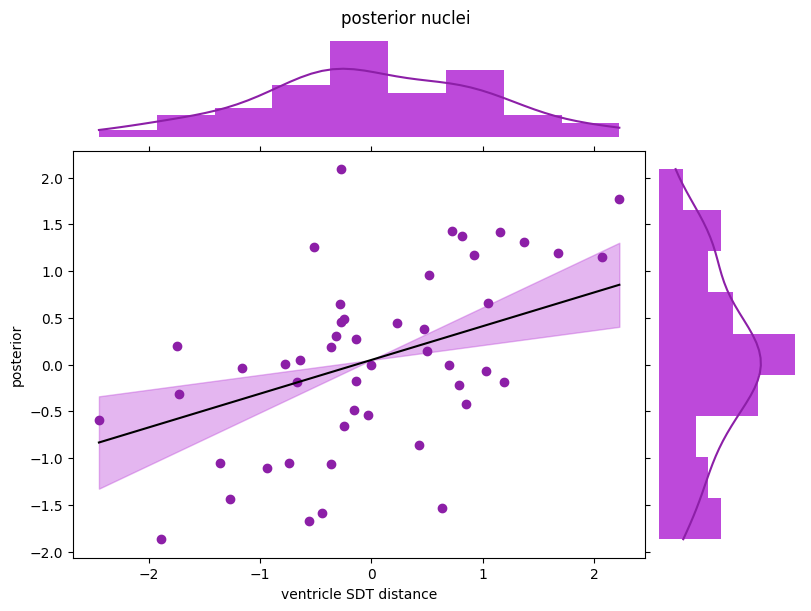

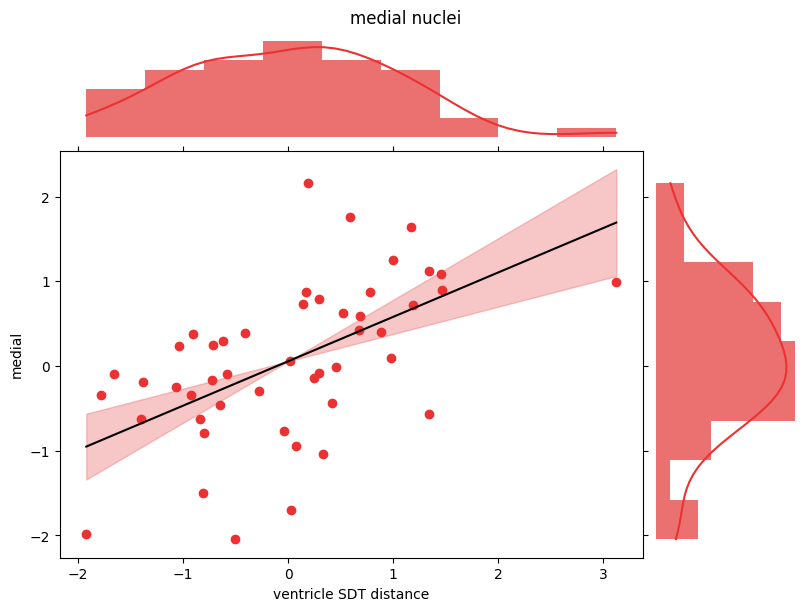

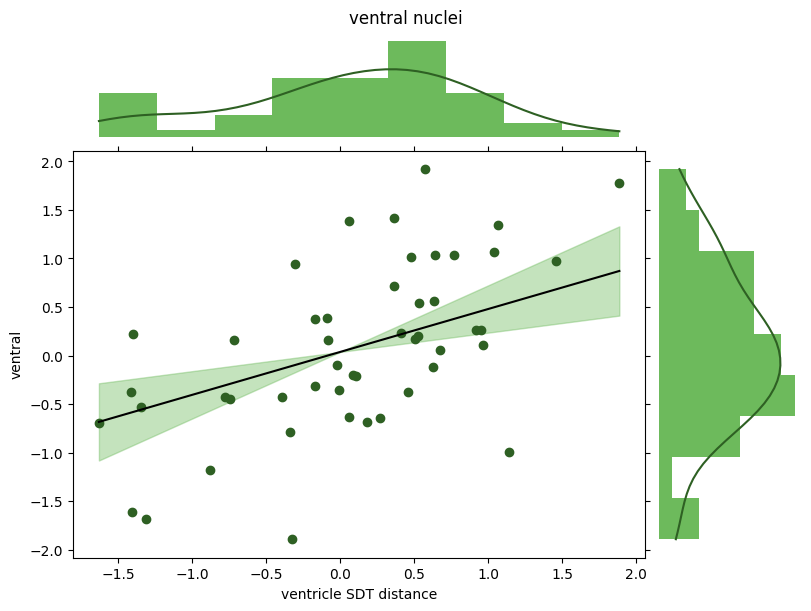

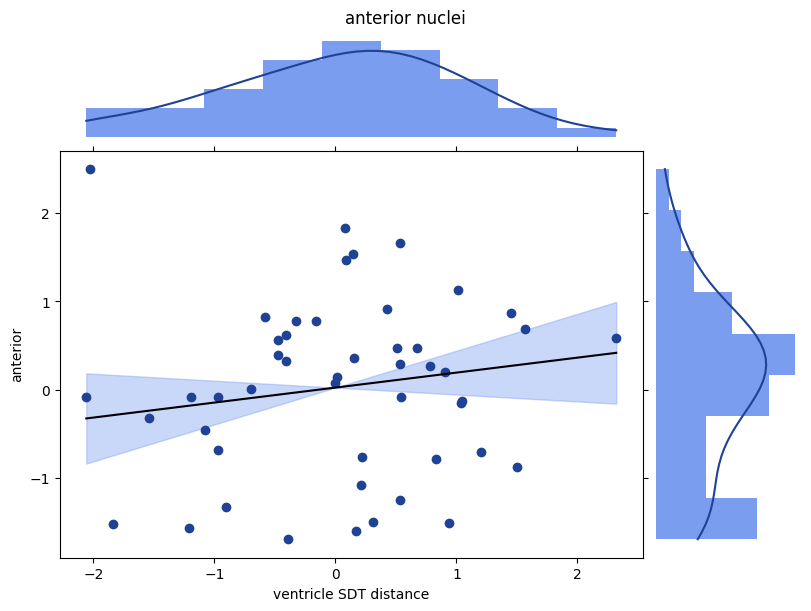

In [10]:
model_data = df_z.join([df_thomas2, ventricle_dists2])
model_data = model_data[model_data['dz_type5'] == "NIND"]

model_data[df_thomas2.columns] = model_data[df_thomas2.columns].apply(stats.zscore, nan_policy='omit')
model_data[ventricle_dists2.columns] = model_data[ventricle_dists2.columns].apply(stats.zscore, nan_policy='omit')

structs = ["posterior", "medial", "ventral", "anterior"]

subids_remove = []
for col in structs:
    check = model_data[col].abs()
    subids_remove.extend(check[check > 4].index.values)
    check = model_data[f"{col}_dist"].abs()
    subids_remove.extend(check[check > 4].index.values)
subids_remove = set(subids_remove)
model_data = model_data.loc[~model_data.index.isin(subids_remove), :]


results = {}
for struct in ["anterior", "medial", "posterior", "ventral"]:
    dist_name = f"{struct}_dist"
    formula = f"{struct} ~ {dist_name} + age + Female + tiv + dzdur"
    results[struct] = sm.OLS.from_formula(formula, data=model_data)

covariates = ['age', 'Female', 'tiv']

color_names = ["purple1", "red1", "green1", "blue1"]
for struct, color in zip(structs, color_names):
    # plot_regression(model_data, f"{struct}_dist", struct, covariates,
    #                 xlim=[-4.2, 3.1], ylim=[-4, 3.6], title=f"{struct} nuclei",
    #                 xlabel="ventricle SDT distance", color=color)
    plot_regression(model_data, f"{struct}_dist", struct, covariates,
                    title=f"{struct} nuclei",
                    xlabel="ventricle SDT distance", color=color)
    # plt.savefig(fig_path / f"{struct}_vs_ventricle_sdt.png", dpi=300)

In [142]:
# model_data = df.join([df_thomas2_z, ventricle_dists2_z])
results = {}
for struct in ["anterior", "medial", "posterior", "ventral"]:
    dist_name = f"{struct}_dist"
    formula = f"{struct} ~ {dist_name} + age + Female + tiv"
    results[struct] = sm.OLS.from_formula(formula, data=model_data).fit()
    print(struct, results[struct].params[dist_name])

anterior 0.24069183529417662
medial 0.5668975671531722
posterior 0.6105917357703579
ventral 0.690924434988151


In [154]:
new_cols = {i: f"{i}_choroid" for i in choroid_dists.columns}
model_cp_dists = choroid_dists.rename(columns=new_cols)
new_cols = {i: f"{i}_ventricle" for i in ventricle_dists_sdt.columns}
model_v_dists = ventricle_dists_sdt.rename(columns=new_cols)
model_data = df_z.join([df_thomas_z, model_cp_dists, model_v_dists])


In [156]:
covariates = "age + Female + tiv"
pvals = {}
coefs = {}
se = {}

structs = hips_thomas_ref[thalamic_nuclei]

all_results = {}
for struct in structs:
    formula = f"{struct} ~ {struct}_dist_ventricle + {struct}_dist_choroid + {covariates}"
    res = sm.OLS.from_formula(formula, data=model_data).fit()
    pvals[struct] = res.pvalues[f"{struct}_dist_choroid"]
    coefs[struct] = res.params[f"{struct}_dist_choroid"]
    se[struct] = res.HC0_se[f"{struct}_dist_choroid"]
    all_results[struct] = res

regression_results = pd.DataFrame({"coef": coefs, "pvals": pvals, "se": se})
regression_results['p_fdr'] = stats.false_discovery_control(
    regression_results['pvals'], method='bh'
)
# regression_results = regression_results.sort_values(by="coef", ascending=True)
regression_results.insert(0, "struct", regression_results.index)
new_index = []
for item in regression_results.struct:
    new_index.append(int(re.match(r".+_(\d+)$", item)[1]))

for i, row in regression_results.iterrows():
    if row['p_fdr'] < 0.05:
        regression_results.loc[i, 'coef_sig'] = row['coef']
    else:
        regression_results.loc[i, 'coef_sig'] = 0

regression_results.index = new_index
regression_results

,struct,coef,pvals,se,p_fdr,coef_sig
2,AV_2,0.033644,1.120113e-03,0.010673,5.600566e-03,0.033644
4,VA_4,0.012998,1.538412e-01,0.008471,3.521918e-01,0.000000
5,VLa_5,0.006034,5.878210e-01,0.009927,6.531344e-01,0.000000
6,VLP_6,0.007739,4.030180e-01,0.009109,5.037725e-01,0.000000
7,VPL_7,0.019610,1.760959e-01,0.014766,3.521918e-01,0.000000
8,Pul_8,0.018940,2.164051e-01,0.013626,3.606751e-01,0.000000
9,LGN_9,0.170843,1.015048e-17,0.022559,1.015048e-16,0.170843
10,MGN_10,0.002588,8.927973e-01,0.017570,8.927973e-01,0.000000
11,CM_11,0.012193,3.843505e-01,0.013679,5.037725e-01,0.000000
12,MD_Pf_12,0.033046,4.444155e-03,0.011321,1.481385e-02,0.033046


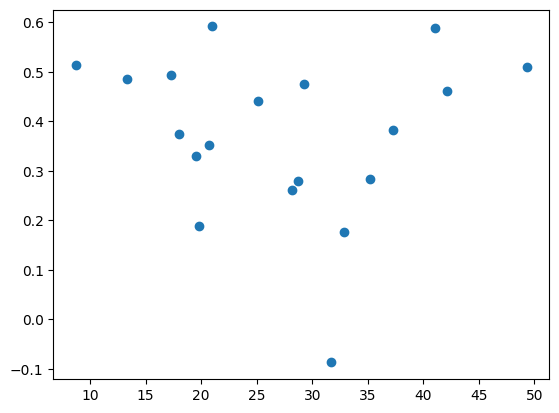

In [104]:
model_data = df.join([df_thomas_z, ventricle_dists_sdt_z])
model_data = model_data[model_data.dz_type2 == "MS"]
model_data = model_data.loc[~model_data.index.isin([2007]), :]

subids_remove = []
for col in ventricle_dists_sdt.columns:
    check = ventricle_dists_sdt_z[col].abs()
    subids_remove.extend(check[check >= 3].index.values)

subids_remove = set(subids_remove)
model_data = model_data.loc[~model_data.index.isin(subids_remove), :]

coefs = {}

for struct in hips_thomas_ref[all_struct_inds]:
    formula = f"{struct} ~ {struct}_dist + age + Female + tiv"
    res = sm.OLS.from_formula(formula, data=model_data).fit()
    coefs[struct] = res.params[f"{struct}_dist"]

coefs_rekey = {int(hips_thomas_invref[k]): v for k, v in coefs.items()}
data = mni_dists.join([pd.Series(coefs_rekey, name="coef")])
data

# data = pd.DataFrame({'coefs': coefs_rekey, 'dists': mni_dists.iloc[0].to_dict()})
# new_index = [int(ind) for ind in data.index]
# data.index = new_index

plt.scatter(data.loc[:, 'left_exposure'], data.loc[:, 'coef'])

In [105]:
data

,left_exposure,right_exposure,struct,coef
index,,,,
2,28.724859,28.201181,AV_2,0.279494
4,29.301275,28.637189,VA_4,0.474229
5,25.154024,24.134354,VLa_5,0.441815
6,20.982216,20.271701,VLP_6,0.591312
7,13.337370,12.456556,VPL_7,0.485448
8,8.712833,8.349248,Pul_8,0.514169
9,19.527532,18.583537,LGN_9,0.330288
10,17.274308,16.610573,MGN_10,0.494249
11,18.029122,17.492163,CM_11,0.374656


In [93]:
mni_choroid_dists

,2,4,5,6,7,8,9,10,11,12,13,14,26,27,28,29,30,31,32
0,5.09902,10.246951,16.792856,11.224972,12.041595,8.544003,17.720045,17.291616,13.928389,11.090536,15.264338,17.888544,23.853722,12.206555,30.822069,19.131126,20.223749,24.269321,26.191601


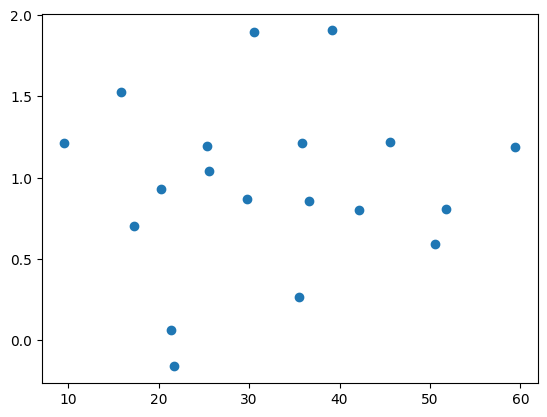

In [49]:
subid = 1012

struct_inds = hips_thomas_ref[~hips_thomas_ref.isin(["THALAMUS_1", "Amy_34", "GP_33"])].index

check = df_thomas_z.loc[subid, hips_thomas_ref[struct_inds]]
check.index = hips_thomas_ref[struct_inds].index

dist_index = hips_thomas_ref.copy()
for i, row in dist_index.items():
    dist_index[i] = f"{row}_dist"

x = choroid_dists.loc[subid, dist_index[struct_inds]]
x.index = dist_index[struct_inds].index

plt.scatter(x, check)

In [39]:
dist_index[2] = f"{dist_index[2]}_dist"
dist_index

index
1     THALAMUS_1
2      AV_2_dist
4           VA_4
5          VLa_5
6          VLP_6
7          VPL_7
8          Pul_8
9          LGN_9
10        MGN_10
11         CM_11
12      MD_Pf_12
13         Hb_13
14        MTT_14
26        Acc_26
27        Cau_27
28        Cla_28
29        GPe_29
30        GPi_30
31        Put_31
32         RN_32
33         GP_33
34        Amy_34
Name: struct, dtype: object

(array([ 54., 339., 160.,  15.,   3.,   1.,   0.,   0.,   0.,   1.]),
 array([ 4.080737  ,  7.00859947,  9.93646194, 12.86432442, 15.79218689,
        18.72004936, 21.64791183, 24.5757743 , 27.50363678, 30.43149925,
        33.35936172]),
 <BarContainer object of 10 artists>)

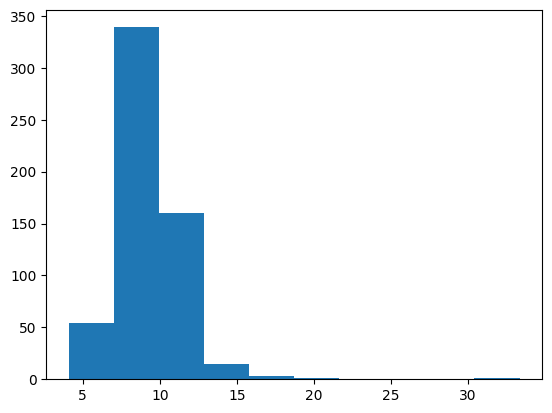

In [10]:
ind = 8
dist_name = f"{hips_thomas_ref[ind]}_dist"
struct = hips_thomas_ref[ind]
plt.hist(choroid_dists[dist_name])

In [104]:
model_data.sort_values(by="Pul_8_dist")

,subject,sz_onset,dzdur,MSSS,gMSSS,ARMSS,sex,age,obs_start_date,obs_end_date,...,MD_Pf_12_dist,Hb_13_dist,MTT_14_dist,Acc_26_dist,Cau_27_dist,Cla_28_dist,GPe_29_dist,GPi_30_dist,Put_31_dist,RN_32_dist
subid,,,,,,,,,,,,,,,,,,,,,
2021,ms2021,11/1/2020,-1.301885,NaN,NaN,-0.532257,Female,-1.039421,8/30/2019,8/30/2019,...,20.882586,19.336411,34.341098,52.313848,43.998270,45.343293,36.896778,34.224295,39.861209,29.184167
1267,ms1267,12/27/2019,-1.084497,0.376012,0.151097,0.490655,Female,-1.755396,1/5/2021,1/5/2021,...,22.416332,18.423869,36.152331,58.384649,51.299097,52.252689,42.631012,39.501381,46.404346,29.431954
1477,ms1477,3/28/2021,-1.106668,-0.380526,-0.467743,-0.099323,Female,-1.962233,1/15/2022,1/15/2022,...,17.993560,18.669202,32.840351,52.772773,42.512913,46.879048,36.470242,34.570958,40.559010,29.989264
2001,ms2001,1/1/2011,-0.595915,-0.425267,-0.359028,-0.977924,Female,0.570860,12/22/2016,12/22/2016,...,15.771339,14.228181,29.819238,53.049016,43.907741,49.172222,38.375681,36.429051,42.983207,26.469768
1364,ms1364,6/1/2010,-0.485328,NaN,NaN,NaN,Female,-1.441162,7/5/2017,7/5/2017,...,21.016838,18.195327,35.705125,56.720618,50.081460,53.190906,42.230788,39.616385,46.549528,29.968650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1072,ms1072,1/1/2015,-0.844937,-0.014459,0.013113,-0.052635,Female,-0.938212,6/15/2018,6/15/2018,...,27.561817,20.807361,37.264459,61.938615,56.416127,66.759256,52.383268,48.914150,59.773203,31.557970
2007,ms2007,6/1/2005,0.042460,-0.852345,-0.844065,-0.850591,Female,0.224143,11/8/2017,11/8/2017,...,17.527839,21.345345,25.114760,40.626305,33.803083,52.181034,36.006878,35.056401,43.645553,28.786253
1068,ms1068,1/1/1996,1.082353,-0.067335,0.126009,0.524610,Female,0.765764,12/20/2018,12/20/2018,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(array([  3.,  18.,  29.,  62., 111., 118.,  80.,  37.,   8.,   1.]),
 array([  62.970985 ,  391.9818211,  720.9926572, 1050.0034933,
        1379.0143294, 1708.0251655, 2037.0360016, 2366.0468377,
        2695.0576738, 3024.0685099, 3353.079346 ]),
 <BarContainer object of 10 artists>)

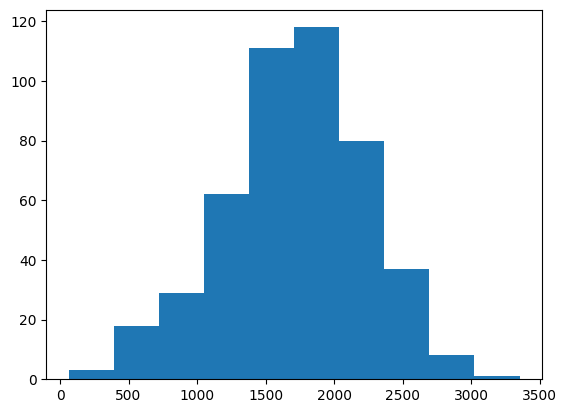

In [102]:
plt.hist(model_data['choroid_volume'])